# Adversarial Robust Deep Hedging
#### Exploring the Heston Model
(Example 7.2)

In [1]:
from typing import Dict
from IPython import display
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from src.deep_hedging.DeepHedge import DeepHedgeConfig, DeepHedge
from src.deep_hedging.DeepHedgeHeston import DeepHedgeHeston, DeepHedgeHestonConfig
from src.deep_hedging.DeepHedgeTrainer import DeepHedgeTrainer, DeepHedgeTrainerConfig
from src.deep_hedging.StrategyNet import StrategyNetConfig
from src.deep_hedging.objectives.HedgeObjective import MeanVariance, Entropy, StableEntropy, Std
from src.derivative.EuropeanCallOption import EuropeanCallOption
from src.gan.RobustDhGan import RobustDhGan
from src.generator.HestonCoefficient import HestonCoefficientConfig, HestonDriftCoefficient, HestonDiffusionCoefficient
from src.generator.SdeGenerator import GeneratorConfig, SdeGenerator
from src.generator.HestonGenerator import HestonGenerator as TrainableHestonGenerator
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainerConfig
from src.penalty.Augmentations import LeadLag, AddTimeComponent
from src.penalty.SigWassersteinMetric import SignatureConfig, SigWassersteinMetric
from src.util.TimeUtil import UniformTimeDiscretization
from src.util.processes.BlackScholesGenerator import BlackScholesGenerator
from src.util.processes.BrownianMotionGenerator import BrownianMotionGenerator
from src.util.processes.HestonGenerator import HestonParameterSet, HestonGenerator
from src.util.torch_util.AdapterUtil import Adapter, AdapterList, SelectDimensions, ConvertToIncrements
from src.util.torch_util.TrainingUtil import TrainerConfig
from src.generator.SdeGeneratorTrainer import SdeGeneratorTrainer
from src.util.torch_util.CallbackUtil import PrintMetrics, PrintGeneratorParameters, PrintEmptyLine
from src.util.VisualizationUtil import QuantityLogger
from src.util.torch_util.TrainingUtil import TrainerConfig, PbarOption, gen_factory
from src.util.ray_util.TqdmUtil import to_limited_iterator
from src.util.PushOverUtil import notify

In [2]:
import ray
import logging
ray.shutdown()
num_cpus = 24
ray.init(num_cpus=num_cpus, logging_level=logging.ERROR)

Python version:,3.8.0
Ray version:,2.0.1


## Initialize

### Reference model and generator 

We begin by initializing the true market model. We choose the following paramters for demonstration. 

In [3]:
heston_parameters = HestonParameterSet(
    drift=0.0,
    reversion_level=0.04,
    reversion_speed=1,
    vol_of_vol=0.2,
    correlation=0.8,
)

Moreover, we need the following market parameters:

In [4]:
trading_freq: int = 5
td = UniformTimeDiscretization(trading_freq * 1. / 255., 90 // trading_freq)
derivative = EuropeanCallOption(strike=1.0, time_discretization=td, price=0.0)

This allows us to define a generator for the true underlying model: 

In [5]:
reference_generator = HestonGenerator(parameter=heston_parameters).provide_generator(
    initial_value=np.array([1.0, heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)

### Generate data with model uncertainty

We now generate `number_of_scenarios` scenarios, where we have a faulty `HestonParameterSet` given, that is obtained by calibration.

In [6]:
number_of_scenarios = 2000

In [7]:
scenarios = [reference_generator(30) for _ in range(number_of_scenarios)]

### Define corresponding penalties

We can now initialize penalties that determine the distance to the generated paths in each scenario. 

In [8]:
pen_config = SignatureConfig(depth=2, augmentations=[AddTimeComponent(td), LeadLag()])
penalizers = [
    SigWassersteinMetric(scenario[:, :, 0:2], pen_config, transform=lambda x: 15000 * x) for scenario in scenarios
]

They measure the distance of generated paths by considering the Sig-Wasserstein Distance. 

In [9]:
reference_model_data = reference_generator(10000)[:, :, 0:2]
ref_pen = SigWassersteinMetric(reference_model_data[:, :, 0:2], pen_config, transform=lambda x: 1000 * x)

In [10]:
# distance_to_reference_model = [pen(reference_model_data) for pen in tqdm(penalizers)]

In [11]:
# fig, axs = plt.subplots(1, 1, figsize=(5,3))
# axs.hist(distance_to_reference_model, bins=41)
# plt.tight_layout()
# plt.show()

### Initialize generators

With this, we can now initialize an `SdeGenerator` that has `HestonDriftCoefficient` and `HestonDiffusionCoefficient` for every observed sample. We initialize these coefficients by the reference parameter set to abbreviate training. 

In [12]:
generators = []
for _ in penalizers:
    coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)
    drift_coef, diffusion_coef = HestonDriftCoefficient(coef_config), HestonDiffusionCoefficient(coef_config)
    gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
    generators.append(TrainableHestonGenerator(generator_config=gen_config))

We disable the training for all drift parameters:

In [13]:
for g in generators:
    g.drift._drift.requires_grad = False

### Noise Generator
In order to utilize the generator (which transforms normal increments to paths), we require a `noise_generator`. In this case, this is a simple Brownian motion increment generator:

In [14]:
noise_generator = BrownianMotionGenerator().provide_increment_generator(
    initial_value=np.zeros(2),
    times=td.times,
    random_number_generator=np.random.default_rng(4444),
)

### Fitting the generators

As a next step, we fit the generators to the corresponding observed samples.

In [15]:
target_folder = 'resources/network-states/test_h'
sample_size = 10000
batch_sizes_for_epoch = 20*[100] + 20*[500] + 10*[1000] + 10*[5000] + 10*[10000]

In [16]:
@ray.remote
def train_gen_remote(i, g, p, noise_generator):
    gt_config = SdeGeneratorTrainerConfig(
        penalizer=p,
        penalization_adapters=AdapterList([SelectDimensions(slice(0,2,1))]),
    )
    t_config = TrainerConfig(sample_size, noise_generator, None)
    gt = SdeGeneratorTrainer(g, gt_config, t_config)
    try:
        return i, gt.get_weights_from_load_and_fitting_procedure(
            f=f'{target_folder}/gen_p/{i}.pt',
            batch_sizes=batch_sizes_for_epoch,
            loss_curve_address=f'{target_folder}/gen_lc/{i}',
            parameter_tracking_address=f'{target_folder}/gen_pt/{i}',
        )
    except RuntimeError:
        print(f'RuntimeError in iteration {i}')
        return i, None

In [17]:
id_gen = (
    train_gen_remote.remote(i=i, g=g, p=p, noise_generator=noise_generator)
    for i, (g, p) in enumerate(zip(generators, penalizers))
)

In [18]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, 12), total=len(generators)):
    if state_dict:
        generators[i].load_state_dict(state_dict)
        torch.save(generators[i].state_dict(), f'{target_folder}/gen_p/{i}.pt') 

For the above fitted generators, we can inspect the loss while fitting and, additionally, the movement of the individual Heston parameters throughout the epochs. 

In [19]:
try: 
    d = np.load(f'{target_folder}/gen_pt/{0}.npy', allow_pickle=True)
    gen_pars = {k: [sd[k] for sd in d] for k in d[0].keys()}

    fig, axs = plt.subplots(2, 3, figsize=(12,8))
    axs = axs.ravel()
    for k, ax in zip(d[0].keys(), axs):
        ax.plot(gen_pars[k])
        ax.set_title(k)
    plt.show()
except FileNotFoundError:
    pass

In [20]:
try:
    plt.plot(np.load(f'{target_folder}/gen_lc/{0}.npy', allow_pickle=True))
    plt.show()
except FileNotFoundError:
    pass

### Test cases

The purpose of the preceding steps is that we have a set of Heston parameters that have some natural uncertainty. For this, recall that we obtain one `HestonParameterSet` by calibrating the Heston model to a small number of paths using the Sig-Wasserstein distance.

Below, for each scenario, the obtained Heston parameters are visualized.

In [21]:
parameter_sets = [
    HestonParameterSet(
        heston_parameters.drift,
        reversion_level=g.drift.reversion_level.item(),
        reversion_speed=g.drift.reversion_speed.item(),
        vol_of_vol=g.diffusion.vol_of_vol.item(),
        correlation=g.diffusion.correlation.item(),
    ) for g in generators
]

In [22]:
distance_to_ref = [
    SigWassersteinMetric(
        g(noise_generator(10000))[:, :, 0:2],
        pen_config,
        transform=lambda x: 15000 * x
    )(reference_model_data).item() for scenario in tqdm(scenarios)
]

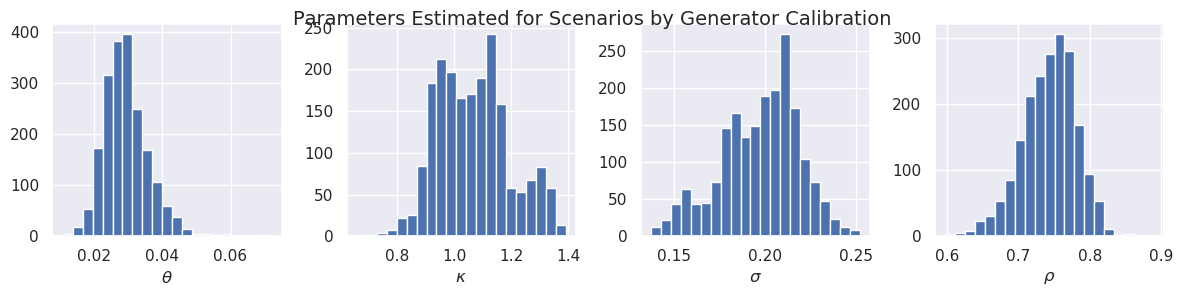

In [23]:
fig, axs = plt.subplots(1,4,figsize=(12,3))
axs[0].hist([ps.reversion_level for ps in parameter_sets], bins=21)
axs[0].set_xlabel(r'$\theta$')
axs[1].hist([ps.reversion_speed for ps in parameter_sets], bins=21)
axs[1].set_xlabel(r'$\kappa$')
axs[2].hist([ps.vol_of_vol for ps in parameter_sets], bins=21)
axs[2].set_xlabel(r'$\sigma$')
axs[3].hist([ps.correlation for ps in parameter_sets], bins=21)
axs[3].set_xlabel(r'$\rho$')
plt.suptitle("Parameters Estimated for Scenarios by Generator Calibration", fontsize=14)
plt.tight_layout()
# plt.savefig('figs/HestonParameters.pdf')
plt.show()

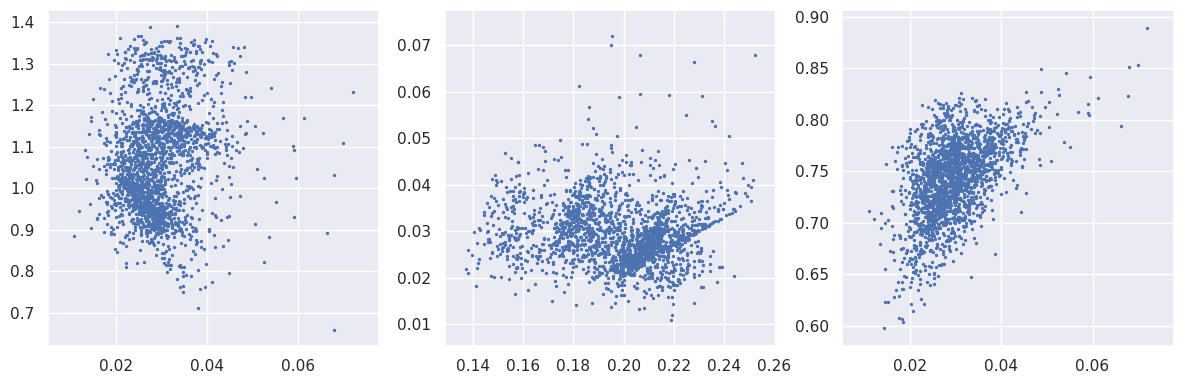

In [24]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].scatter([ps.reversion_level for ps in parameter_sets], [ps.reversion_speed for ps in parameter_sets], s=2)
axs[1].scatter([ps.vol_of_vol for ps in parameter_sets], [ps.reversion_level for ps in parameter_sets], s=2)
axs[2].scatter([ps.reversion_level for ps in parameter_sets], [ps.correlation for ps in parameter_sets], s=2)
plt.tight_layout()
plt.show()

For each of the above Heston parameters we are now able to generate data. This, in comparison to the reference generator, is displayed below.

In [25]:
arbitrary_test_data = generators[0](noise_generator(100)).detach().numpy()
arbitrary_reference_data = reference_generator(100)

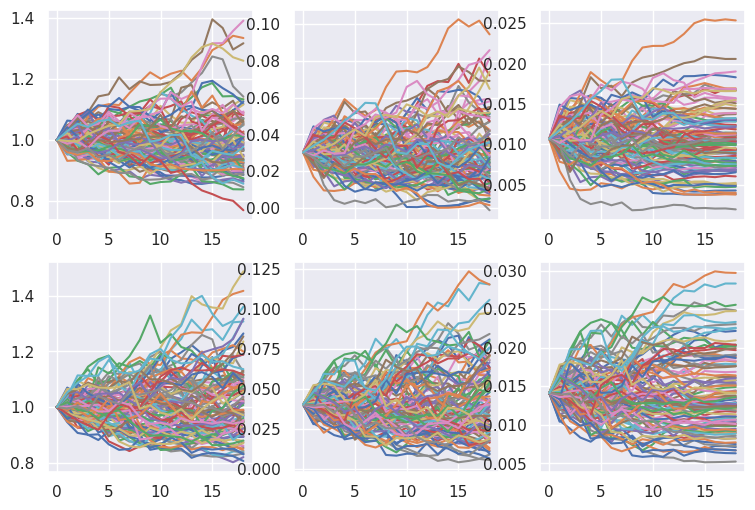

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i in range(3):
    axs[0, i].plot(arbitrary_test_data[:, :, i].T)
    axs[1, i].plot(arbitrary_reference_data[:, :, i].T)
plt.show()

## Deep Hedging

We will now train a deep hedge on each of the individual models. This has tow purposes

1. we use these deep hedges as pre-trained components for the actual application of the robust hedge GAN, and
2. we will use these hedges to compare the robust hedge GAN on out-of-sample generated data against.

### Initialization 

We begin by setting a hedging objective, since it remains the same over all models. 

In [27]:
hedge_objective = MeanVariance(84)

Next, we define the deep hedges. Beginning with the reference hedge, which has the purpose to speed up the computational cost of our test. Note that in real life application, this is not possible. However, since we do not use this `ref_hedge` in our evaluation later, this is does not infer with our findings. 

In [28]:
coef_config = HestonCoefficientConfig(heston_parameters, initial_asset_price=1.0)
drift_coef, diffusion_coef = HestonDriftCoefficient(coef_config), HestonDiffusionCoefficient(coef_config)
gen_config = GeneratorConfig(td, drift_coef.get_initial_asset_price, drift_coef, diffusion_coef)
ref_gen = TrainableHestonGenerator(generator_config=gen_config)

ref_hedge = DeepHedgeHeston(
    DeepHedgeHestonConfig(
        derivative=derivative,
        initial_information_value=torch.tensor([
                1.0,
                heston_parameters.reversion_level,
                HestonGenerator(parameter=heston_parameters).get_correction_term(
                    td.maturity,
                    heston_parameters.reversion_level),
            ], dtype=torch.float32),
        strategy_config=StrategyNetConfig(
            dim_of_information_process=2,
            dim_of_tradable_asset=2,
            number_of_layers=2,
            nodes_in_intermediate_layers=100,
        ),
    )
)

In [29]:
deep_hedges = []
for ps in parameter_sets:
    deep_hedges.append(
        DeepHedgeHeston(
            DeepHedgeHestonConfig(
                derivative=derivative,
                initial_information_value=torch.tensor([
                        1.0,
                        heston_parameters.reversion_level,
                        HestonGenerator(parameter=ps).get_correction_term(
                            td.maturity,
                            heston_parameters.reversion_level),
                    ], dtype=torch.float32),
                strategy_config=StrategyNetConfig(
                    dim_of_information_process=2,
                    dim_of_tradable_asset=2,
                    number_of_layers=2,
                    nodes_in_intermediate_layers=100,
                ),
            )
        )
    )

We can now train the reference hedge, which is done on multiple epochs of (initially) small-batched data.

In [30]:
sample_size = 100000
batch_sizes_for_epoch = [100]*3 + [1000]*1 + [10000]*2

In [31]:
ref_hedge_address = f'{target_folder}/ref_hedge.pt'
ref_dht = DeepHedgeTrainer(
    dh=ref_hedge,
    config=DeepHedgeTrainerConfig(hedge_objective),
    trainer_config=TrainerConfig(sample_size, gen_factory(ref_gen, noise_generator), None),
)
torch.save(
    ref_dht.get_weights_from_load_and_fitting_procedure(
        f=ref_hedge_address,
        batch_sizes=batch_sizes_for_epoch,
        pbar_option=PbarOption.VANISHING_BATCH_BAR,
    ), 
    ref_hedge_address,
) 

Now it is possible to adapt the hedge to the corresponding generator by a smaller training effort. We train a `deep_hedge` for every scenario that are presented as generators.

In [32]:
sample_size = 10000
batch_sizes_for_epoch = 10*[100] + 10*[5000] 

In [33]:
@ray.remote
def train_dh_remote(
    i,
    g,
    dh,
    hedge_objective,
    sample_size,
    noise_generator,
    batch_sizes_for_epoch,
    folder_to_load_from,
    pretrained,
):
    dht_config = DeepHedgeTrainerConfig(hedge_objective)
    t_config = TrainerConfig(sample_size, gen_factory(g, noise_generator), None)
    dht = DeepHedgeTrainer(
        dh=dh,
        config=dht_config,
        trainer_config=t_config,
    )
    return i, dht.get_weights_from_load_and_fitting_procedure(
        f=f'{target_folder}/{folder_to_load_from}/{i}.pt',
        batch_sizes=batch_sizes_for_epoch,
        pretrained=ref_hedge_address,
        loss_curve_address=f'{target_folder}/hedge_lc/{i}'
    )
    

In [34]:
id_gen = (train_dh_remote.remote(
    i=i,
    dh=dh,
    g=g,
    hedge_objective=hedge_objective,
    sample_size=sample_size,
    noise_generator=noise_generator,
    batch_sizes_for_epoch=batch_sizes_for_epoch,
    folder_to_load_from='hedge_p',
    pretrained='ref_hedge.pt',
) for i, (dh, g) in enumerate(zip(deep_hedges, generators)))

In [35]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, num_cpus), total=len(deep_hedges)):
    deep_hedges[i].load_state_dict(state_dict)
    torch.save(deep_hedges[i].state_dict(), f'{target_folder}/hedge_p/{i}.pt') 

With that, we can display an exemplary loss curve.

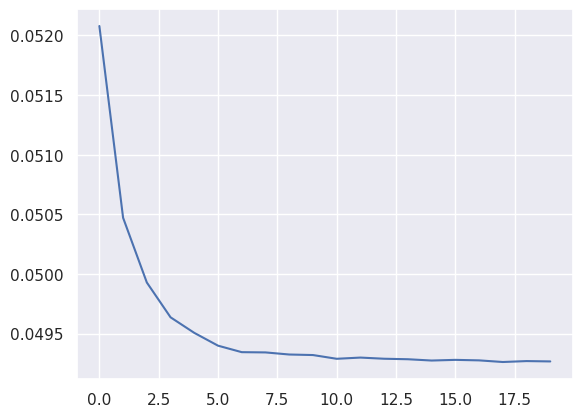

In [36]:
for i in [999]:
    plt.plot(np.load(f'{target_folder}/hedge_lc/{i}.npy', allow_pickle=True))

### Testing

We now showcase the performance of the individual deep hedges. For this, we generate a large set of `test_data` from the (re-initialized) reference generator.

In [37]:
reference_generator = HestonGenerator(parameter=heston_parameters).provide_generator(
    initial_value=np.array([1.0, heston_parameters.reversion_level]),
    times=td.times,
    random_number_generator=np.random.default_rng(1111),
)
test_data = torch.diff(reference_generator(10000), 1, 1)

First, we apply the reference hedge to the `test_data`.

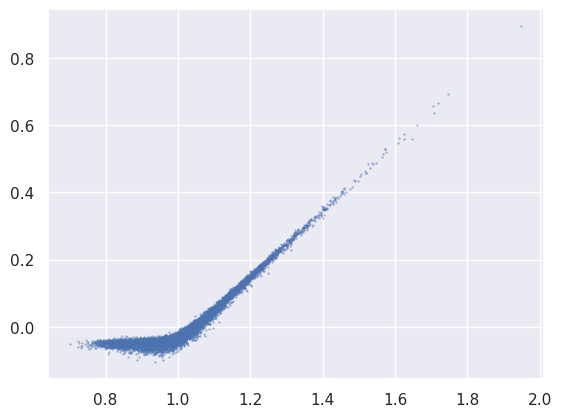

In [38]:
ref_hedge.eval()
deep_hedge_results = np.sum(ref_hedge(test_data).detach().numpy() * test_data.numpy()[:, :, (0,2)], axis=(1))
terminal_values_on_test = np.sum(test_data.numpy(), axis=(1))[:, 0] + 1.0
plt.scatter(terminal_values_on_test, np.sum(deep_hedge_results, axis=1), s=.1)
# plt.scatter(terminal_values_on_test, derivative.payoff_for_terminal_asset_values(torch.sum(test_data, dim=1) + 1), s=.1)
ref_hedge.train()
plt.show()

Now, we can compute the performance (in terms of utility) of every individual hedge on the test data. 

In [39]:
oosp = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

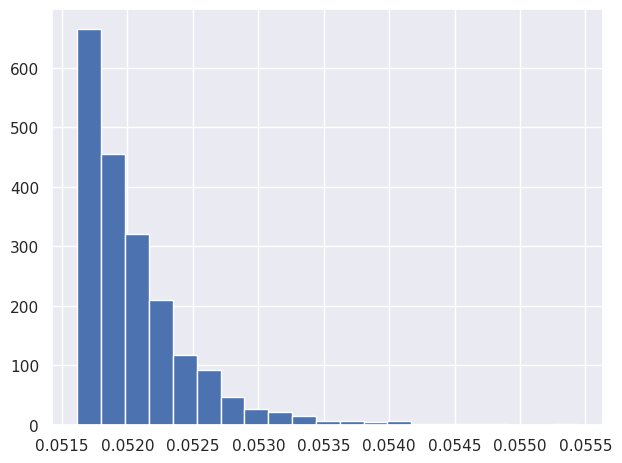

In [40]:
plt.hist(oosp, bins=21)
plt.tight_layout()
plt.show()

In [41]:
# plt.scatter(distance_to_ref, oosp, s=1)
# plt.tight_layout()
# plt.show()

## Robust Hedge GAN

Now we fulfill all prerequisites to train adversarially. This is done below for every scenario.

In [42]:
sample_size = 10000
batch_sizes_for_epoch = 10*[1000] + 10*[5000]

In [43]:
robust_dh_gans = []
for dh, p, g in zip(deep_hedges, penalizers, generators):
    dht_config = DeepHedgeTrainerConfig(
        hedge_objective=hedge_objective,
        generation_adapters=AdapterList([ConvertToIncrements()]),
    )
    gt_config = SdeGeneratorTrainerConfig(
        penalizer=p,
        penalization_adapters=AdapterList([SelectDimensions(slice(0,2,1))]),
    )
    t_config = TrainerConfig(sample_size, noise_generator, None)
    robust_dh_gans.append(RobustDhGan(
        dh=dh, 
        hedge_config=dht_config,
        gen=g,
        gen_config=gt_config,
        trainer_config=t_config,
    ))

In [44]:
@ray.remote
def train_rhgan_remote(i, rhg):
    return i, rhg.get_weights_from_load_and_fitting_procedure(
        f=f'{target_folder}/rhgan_p/{i}.pt',
        batch_sizes=batch_sizes_for_epoch,
        loss_curve_address=f'{target_folder}/rhgan_lc/{i}',
        parameter_tracking_address=f'{target_folder}/rhgan_pt/{i}',
    )
    

In [45]:
id_gen = (train_rhgan_remote.remote(i=i, rhg=rhg) for i, rhg in enumerate(robust_dh_gans))

In [46]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, num_cpus//2), total=len(robust_dh_gans)):
    robust_dh_gans[i].load_state_dict(state_dict)
    torch.save(robust_dh_gans[i].state_dict(), f'{target_folder}/rhgan_p/{i}.pt') 

(train_gen_remote pid=2117538) E1026 16:07:04.006708162 2117538 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(train_gen_remote pid=2117534) E1026 16:07:03.992630301 2117534 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(train_gen_remote pid=2117542) E1026 16:07:03.986903680 2117542 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(train_gen_remote pid=2117536) E1026 16:07:04.000288819 2117536 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


#### Out of sample performance

In [47]:
oosp_robust = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

### Post-training of Deep Hedge

Since we want to ensure a fair comparison between the *robust hedge GAN* and the corresponding *generator-deep hedge pair*, we continue the training of each deep hedge in its respective state before adversarial training. This will make sure that the *generator-deep hedge pair* does not suffer from a lower amount of training than the deep hedge that was trained adversarially.

In [48]:
sample_size = 10000
batch_sizes_for_epoch = 10*[1000] + 10*[5000]

In [49]:
for i, g in enumerate(generators):
    g.load_state_dict(torch.load(f=f'{target_folder}/gen_p/{i}.pt'))

In [50]:
id_gen = (train_dh_remote.remote(
    i=i,
    dh=dh,
    g=g,
    hedge_objective=hedge_objective,
    sample_size=sample_size,
    noise_generator=noise_generator,
    batch_sizes_for_epoch=batch_sizes_for_epoch,
    folder_to_load_from='hedge_pp',
    pretrained=f'hedge_p/{i}.pt',
) for i, (dh, g) in enumerate(zip(deep_hedges, generators)))

In [51]:
for i, state_dict in tqdm(to_limited_iterator(id_gen, num_cpus), total=len(deep_hedges)):
    deep_hedges[i].load_state_dict(state_dict)
    torch.save(deep_hedges[i].state_dict(), f'{target_folder}/hedge_pp/{i}.pt') 

#### Out of sample performance

We therefore recalculate the out-of-sample performance.

In [52]:
oosp = [hedge_objective(dh(test_data)).item() for dh in tqdm(deep_hedges)]

In [53]:
print('Naive:  ', np.mean(oosp))
print('Robust: ', np.mean(oosp_robust))
print()
print('Naive:  ', np.std(oosp))
print('Robust: ', np.std(oosp_robust))

Naive:   0.05212200669571757
Robust:  0.05199511977285147

Naive:   0.0004917478299256238
Robust:  0.00042966237258102715


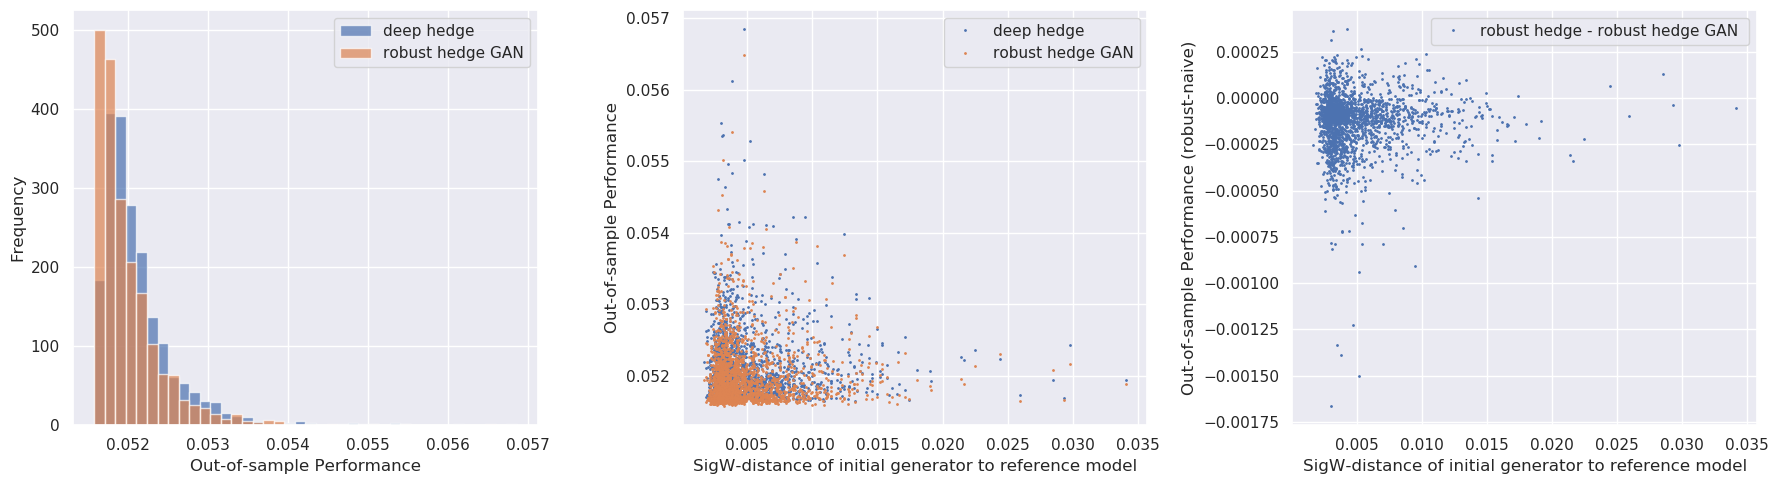

In [61]:
fig, axs = plt.subplots(1, 3, figsize = (18, 5))

vals_n, bins = np.histogram(oosp + oosp_robust, bins=40)
vals_r = np.histogram(oosp_robust, bins=bins)[0]
bin_centers = 0.5*(bins[1:]+bins[:-1])
axs[0].hist(oosp, bins=bins, label='deep hedge', color='C0', alpha=.7)
axs[0].hist(oosp_robust, bins=bins, label='robust hedge GAN', color='C1', alpha=.7)
axs[0].set_xlabel('Out-of-sample Performance')
axs[0].set_ylabel('Frequency')
# axs[0].set_yscale('log')
axs[0].legend()
# axs[0].set_title('')

axs[1].plot(distance_to_ref, oosp, label='deep hedge', marker='o', ls='', ms=1, c='C0')
axs[1].plot(distance_to_ref, oosp_robust, label='robust hedge GAN', marker='o', ls='', ms=1, c='C1')
axs[1].set_xlabel('SigW-distance of initial generator to reference model')
axs[1].set_ylabel('Out-of-sample Performance')
axs[1].legend()
# axs[1].set_title()

axs[2].plot(distance_to_ref, np.array(oosp_robust) - np.array(oosp), label='robust hedge - robust hedge GAN ', marker='o', ls='', ms=1, )
axs[2].set_xlabel('SigW-distance of initial generator to reference model')
axs[2].set_ylabel('Out-of-sample Performance (robust-naive)')
axs[2].legend()

plt.tight_layout()
plt.savefig('figs/HestonRobustification.pdf')
plt.show()